In [0]:
import os
import requests
import base64
import json

input_image_path = "chase template.png"
with open(input_image_path, "rb") as input_image:
    input_image_encoded_image = base64.b64encode(input_image.read()).decode('UTF-8')
    
url = 'https://vision.googleapis.com/v1/images:annotate?key={}'.format(os.environ["GCP_VISION_API_KEY"])
payload = {
  "requests": [
    {
      "image": {
        "content": input_image_encoded_image
#           "source":{
#             "imageUri": input_image_uri
#           }
      },
      "features": [
        {
          "type": "TEXT_DETECTION"
        }
      ]
    }
  ]
}
headers = {'content-type': 'application/json', 'Accept-Charset': 'UTF-8'}
res = requests.post(url, data=json.dumps(payload), headers=headers)
res_json = res.json()

In [115]:
# page1 = res_json["responses"][0]["fullTextAnnotation"]["pages"][0]
# page1_blocks = page1["blocks"]
# for block in page1_blocks:
#   if "paragraphs" in block.keys():
#     for paragraph in block["paragraphs"]:
#         print(paragraph["words"])

# res_json["responses"][0]["textAnnotations"]
import sys

text_annotations = res_json["responses"][0]["textAnnotations"]
transactions_y = None
finance_charges_y = None
for block in text_annotations:
    if "TRANSACTIONS" in block["description"] and "boundingPoly" in block.keys():
      transactions_y = block["boundingPoly"]["vertices"][0]["y"]
    elif "FINANCE" in block["description"] and "boundingPoly" in block.keys():
      finance_charges_y = block["boundingPoly"]["vertices"][0]["y"]
if not transactions_y or not finance_charges_y:
  print("could not find 'TRANSACTIONS' or 'FINANCE CHARGES' block. Exiting...")
  sys.exit(1)
  
transaction_row_font_size = 10
all_xs = []
all_ys = []
for block in text_annotations:
  if "boundingPoly" in block.keys() \
    and block["boundingPoly"]["vertices"][0]["y"] > transactions_y \
    and block["boundingPoly"]["vertices"][0]["y"] < finance_charges_y:
    all_xs.append(block["boundingPoly"]["vertices"][0]["x"])
    all_ys.append(block["boundingPoly"]["vertices"][0]["y"])
    
all_xs.sort()
# buffered_xs = [all_xs[0]]
# valued_xs = {set(buffered_xs)}
valued_xs = [all_xs[0]]
for x in all_xs:
  is_new_column = True
  for vx in valued_xs:
    if (x < (vx + 10) and x > (vx - 10)):
      is_new_column = False
      break
  if is_new_column:
#     print("appending")
#     valued_xs.add(x)
      valued_xs.append(x)
#   print(valued_xs)    
valued_xs.sort()
final_valued_xs = [valued_xs[0], valued_xs[1], valued_xs[4], valued_xs[-3], valued_xs[-1]]
print(final_valued_xs)

all_ys.sort()
valued_ys = [all_ys[0]]
for y in all_ys:
  is_new_row = True
  for vy in valued_ys:
    if (y < (vy + 10) and y > (vy - 10)):
      is_new_row = False
      break
  if is_new_row:
      valued_ys.append(y)  
valued_ys.sort()
final_valued_ys = valued_ys
print(final_valued_ys)
    
# print(transactions_y)

[87, 112, 230, 503, 560]
[628, 639, 655, 668, 681, 694, 707, 720, 733, 746, 759, 771, 782, 793, 804, 817, 830, 843, 869, 882, 928, 939, 980]


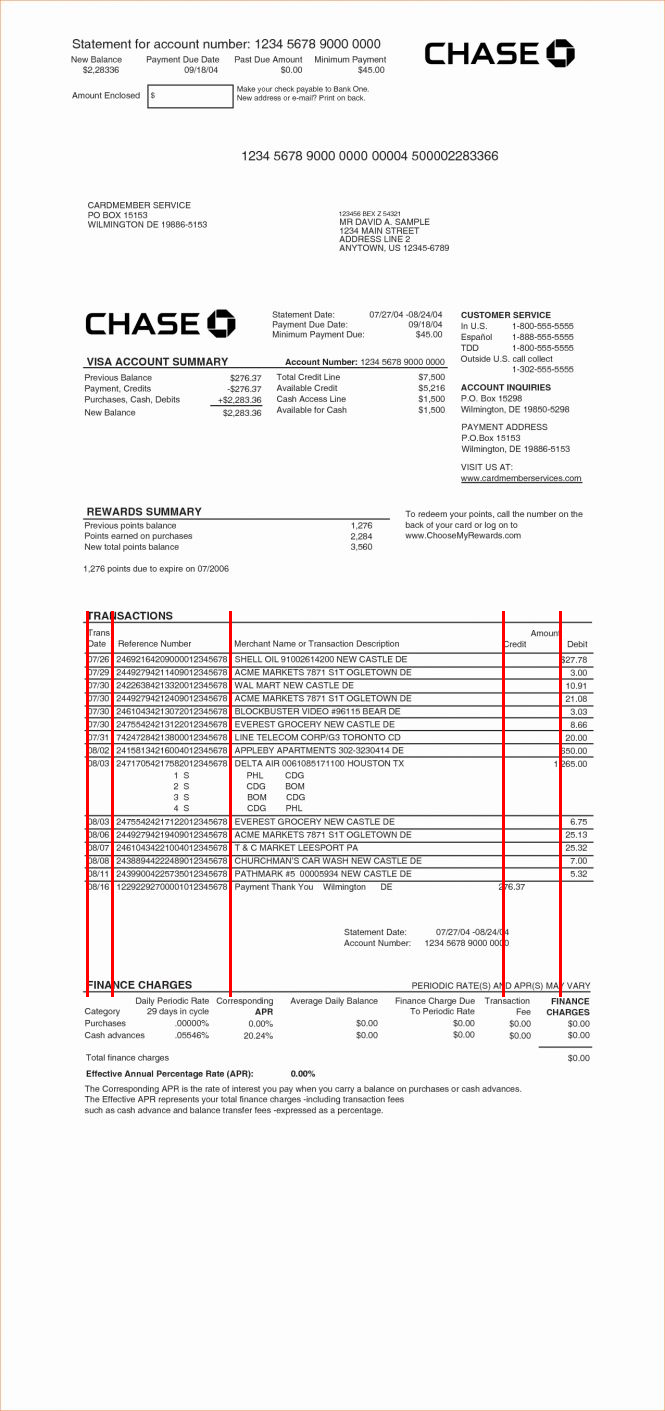

In [112]:
from PIL import Image, ImageDraw
 
input_image_obj = Image.open(input_image_path).convert("RGBA")

draw = ImageDraw.Draw(input_image_obj)

for x in final_valued_xs:
  draw.line((x, transactions_y, x, finance_charges_y), fill="red", width = 3)
input_image_obj